## Dataset Description 

https://github.com/walkerkq/musiclyrics

Billboard has published a Year-End Hot 100 every December since 1958. The chart measures the performance of singles in the U.S. throughout the year. Using R, I’ve combined the lyrics from 50 years of Billboard Year-End Hot 100 (1965-2015) into one dataset for analysis. You can download that dataset here.

The songs used for analysis were scraped from Wikipedia’s entry for each Billboard Year-End Hot 100 Songs (e.g., 2014). This is the year-end chart, not weekly rankings. Many artists have made the weekly chart but not the final year end chart. The final chart is calculated using an inverse point system based on the weekly Billboard charts (100 points for a week at number one, 1 point for a week at number 100, etc).

I used the xml and RCurl packages to scrape song and artist names from each Wikipedia entry. I then used that list to scrape lyrics from sites that had predictable URL strings (for example, metrolyrics.com uses metrolyrics.com/SONG-NAME-lyrics-ARTIST-NAME.html). If the first site scrape failed, I moved onto the second, and so on. About 78.9% of the lyrics were scraped from metrolyics.com, 15.7% from songlyrics.com, 1.8% from lyricsmode.com. About 3.6% (187/5100) were unavailable.

The dataset features 5100 observations with the features rank (1-100), song, artist, year, lyrics, and source. The artist feature is fairly standardized thanks to Wikipedia, but there is still quite a bit of noise when it comes to artist collaborations (Justin Timberlake featuring Timbaland, for example). If there were any errors in the lyrics that were scraped, such as spelling errors or derivatives like "nite" instead of "night," they haven't been corrected.

Full analysis can be found here.

# Imports and Data Loading

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

from Levenshtein import distance as levenshtein_distance

import matplotlib.pyplot as plt

### Lyrics Top-100 dataset

In [ ]:
data_file_incomplete = "datasets/billboard_lyrics_1964-2015.csv"
data_file = "datasets/billboard_full.csv"

df_incomplete = pd.read_csv(data_file_incomplete, encoding = "ANSI") # utf-8 encoding doesn't work somehow :(
df = pd.read_csv(data_file, index_col=0, header=0, sep=",") 

df.head()

In [ ]:
len(df.Artist.unique())

## Number of years in Top 100 per Song

In [ ]:
df_count = df.groupby(["Artist", "Song"]).Year.agg(list).to_frame()
df_count["Count"] = df_count.Year.apply(len)
df_count = df_count.sort_values("Count", ascending = False)
df_count.head()

In [ ]:
plt.pie(df_count["Count"].value_counts(), labels = [1, 2], autopct='%1.1f%%')
plt.show()

## Genre

In [ ]:
vc_genre = df.Genre.value_counts()
vc_genre = vc_genre[vc_genre > 70] # Filter very unfrequent

plt.figure(figsize=(10,6))
plt.pie(vc_genre.values, labels = vc_genre.index, autopct='%1.1f%%')
# plt.savefig("images/genre_distribution.png")
plt.show()

## Number of songs in top 100 per artist (if a song is twice, is counted twice)

In [ ]:
df.Artist.value_counts().describe()

In [ ]:
df_songCounts = df.groupby("Artist").Song.count()
df_rndArtist = df_songCounts.to_frame().reset_index().groupby("Song").agg(list)
df_rndArtist["Artist"] = df_rndArtist["Artist"].apply(lambda a : np.random.choice(a, 1)[0])

df_labels = pd.DataFrame(range(1, df_songCounts.max() + 1), columns = ["Song"])
df_labels["Artist"] = ""
df_labels = df_labels.set_index("Song")
df_labels.update(df_rndArtist)

In [ ]:
tmp = df_songCounts.value_counts()
tmp[tmp.index <= 3].sum() / tmp.sum()

In [ ]:
bins = range(1, df_songCounts.max() + 1)
plt.figure(figsize=(12,6))
plt.hist(df_songCounts, bins = bins)
plt.xticks(bins, df_labels["Artist"], rotation='vertical')
plt.yscale("log")
plt.title("Number of times appearing in Top-100 per Artist, with randomly selected artist per bin")
# plt.savefig("images/songs_per_artist.png", bbox_inches='tight')
plt.show()

## Lyrics statistics

In [ ]:
lyrics_lengths = df.Lyrics.apply(lambda s : len(s.split(" ")))

bins = range(1, 1000)
plt.hist(lyrics_lengths, bins = bins)
plt.title("Number of words per song")
plt.savefig("words.png")
plt.show()

In [ ]:
lyrics_lengths.describe()

In [ ]:
lyrics_lengths_unique = df.Lyrics.apply(lambda s : len(set(s.split(" "))))

bins = range(1, 1000)
plt.hist(lyrics_lengths_unique, bins = bins)
plt.title("Number of unique words per song")
plt.savefig("unique_words.png")
plt.show()

In [ ]:
lyrics_lengths_unique.describe()

### Clusterisation of texts

In [ ]:
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

def lemmatize(token, pos_tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(pos_tag[0], wn.NOUN)
    return lemmatizer.lemmatize(token, tag)

def preprocess_lyrics(lyrics):
    tagged_tokens = pos_tag(wordpunct_tokenize(lyrics))
    preprocessed = [lemmatize(token, tag) for (token, tag) in tagged_tokens if not token in stop_words]
    return " ".join(preprocessed)

In [ ]:
preprocessed_lyrics = df.Lyrics.fillna("").apply(preprocess_lyrics)

In [ ]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english', preprocessor = None)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(preprocessed_lyrics)

In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 4
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

In [ ]:
vectors_10 = lda.transform(count_data)

In [ ]:
plt.scatter(vectors_10[:100, 0], vectors_10[:100, 1], color = "red")
plt.scatter(vectors_10[5000:, 0], vectors_10[5000:, 1], color = "blue")

plt.show()

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
vectors_2 = svd.fit_transform(vectors_10)

In [ ]:
plt.scatter(vectors_2[:100, 0], vectors_2[:100, 1], color = "red")
plt.scatter(vectors_2[5000:, 0], vectors_2[5000:, 1], color = "blue")

plt.show()

## Using Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc.split(" "), [i]) for i, doc in enumerate(df.Lyrics.fillna(""))]
model = Doc2Vec(documents, vector_size=300, window=4, min_count=1, workers=4, epochs = 10, dbow_words = 1)

In [ ]:
sentence = "I cant get no satisfaction"
vector = model.infer_vector(sentence.split(" "))
documents[model.docvecs.most_similar([vector])[1][0]]

In [ ]:
documents[4480]

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
vectors_2 = svd.fit_transform(model.docvecs.vectors_docs)

In [ ]:
plt.scatter(vectors_2[:100, 0], vectors_2[:100, 1], color = "red")
plt.scatter(vectors_2[5000:, 0], vectors_2[5000:, 1], color = "blue")

plt.show()

## Events

In [ ]:
import pandas as pd
import spacy
from spacy import displacy

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

nlp = spacy.load("en_core_web_sm")

In [ ]:
event_filepath = "datasets/events_full.csv"

df_events = pd.read_csv(event_filepath, index_col=0)
df_events.xs(0).Content

In [ ]:
df_events.head()

In [ ]:
def entity_extractor(cols, song = False):
    """
    Parametrable extraction
    """
    ignore_entities = ["CARDINAL", "MONEY", "ORDINAL", "QUANTITY", "TIME"]
    def extract_entities(row):
        """
        Actual extraction
        """
        entities = []
        for col in cols:
            if type(row[col]) == str:
                entities += [(ent.text, ent.label_) for ent in nlp(row[col]).ents if ent.label_ not in ignore_entities]
                
        if song : 
            entities.append((row["Artist"], "PERSON"))
            entities.append((row["Song"], "WORK_OF_ART"))
        
        return entities
    
    return extract_entities

In [ ]:
extraction_cols = ["Content", "Summary"]
df_events["Entities"] = df_events.progress_apply(entity_extractor(extraction_cols), axis = 1)

In [ ]:
df["Entities"] = df.progress_apply(entity_extractor(["Lyrics"]), axis = 1)

In [ ]:
def find_refs(song_rows):
    refs = []
    for entity, label in song_rows.Entities:
        for i, row in df_events.Entities.iteritems():
            ents_lower = [ent.lower() for ent, lab in row]
            if any([entity in low_ent or low_ent in entity for low_ent in ents_lower]):
                refs.append(i)
    return refs

In [ ]:
"""
Add references to events in songs
"""
df["Refs"] = df.progress_apply(find_refs, axis = 1)
df["Refs"] = df["Refs"].apply(set)

In [ ]:
df.filteredRefs

In [78]:
"""
Add references to songs in events
"""
df_events["filteredRefs"] = [[] for i in range(len(df_events))]
for i_song, refs in tqdm_notebook(df["filteredRefs"].iteritems()):
    for i_event in refs:
        df_events.iloc[i_event]["filteredRefs"].append(i_song)
        
df_events["filteredRefs"] = df_events["filteredRefs"].apply(set)

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
"""
Add references to songs in events
"""
df_events["Refs"] = [[] for i in range(len(df_events))]
for i_song, refs in tqdm_notebook(df["Refs"].iteritems()):
    for i_event in refs:
        df_events.iloc[i_event]["Refs"].append(i_song)
        
df_events["Refs"] = df_events["Refs"].apply(set)

In [ ]:
df["Refs"].apply(len)

In [ ]:
df.xs(4971).Lyrics

In [ ]:
s = dict()
for ents in df.Entities.apply(lambda x : [e[0] for e in x]).values:
    for ent in ents :
        if ent in s:
            s[ent] +=1
        else :
            s[ent] = 1

In [ ]:
s = {k: v for k, v in sorted(s.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
df_events[df_events.Wikipedia.isna()]

In [ ]:
df_events[(df_events.Wikipedia.isna()) & df_events.Content.str.contains("Anniversary")].Content

In [ ]:
df_events[(df_events.Year == 2001)& (df_events.Month == "September")]

In [ ]:
df_events.xs(811).Entities

In [ ]:
len(df_events.xs(811).Refs)

In [ ]:
df [(df.Year > 2001) & (df.Lyrics.str.contains("twin"))]

In [ ]:
"""
See the all the types of entities recognized
"""

ent_types = set()
for s in df["Entities"].apply(lambda x : set([e[1] for e in x])):
    for ent in s:
        ent_types.add(ent)
ent_types

In [ ]:
df.to_csv("songs_with_refs.csv")
df_events.to_csv("events_with_refs.csv")

In [32]:
with open("datasets/songs_with_refs.pickle", "wb") as f :
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)
    
with open("datasets/events_with_refs.pickle", "wb") as f :
    pickle.dump(df_events, f, pickle.HIGHEST_PROTOCOL)

# Load refs

In [7]:
with open("datasets/songs_with_refs.pickle", "rb") as f :
    df = pickle.load(f)
    
with open("datasets/events_with_refs.pickle", "rb") as f :
    df_events = pickle.load(f)

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

all_docs = np.concatenate((df.Lyrics.fillna(""), df_events.Content.fillna("")))

documents = [TaggedDocument(doc.split(" "), [i]) for i, doc in enumerate(all_docs)]
model = Doc2Vec(documents, vector_size=300, window=4, min_count=1, workers=4, epochs = 10, dbow_words = 1)

In [ ]:
lyrics2events_sim = []
for i in tqdm_notebook(range(len(df))):
    sims = model.docvecs.most_similar(positive = [model.docvecs[i]], topn=100, clip_start=len(df))[1:]
    sims = [x for x in sims if (x[0] - len(df)) in df.xs(i).Refs]
    sims_refs = sorted(sims, key = lambda x : x[1], reverse=True)[:10]
    lyrics2events_sim.append(sims_refs)
df["Similar"] = lyrics2events_sim

In [ ]:
df[df.Similar.apply(len) > 0].head()

## BERT

In [3]:
from transformers import AlbertModel, AlbertTokenizer
from tqdm import tqdm_notebook
import torch

tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')
model = AlbertModel.from_pretrained('albert-large-v2')
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SimonRoquette\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SimonRoquette\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\SimonRoquette\Anaconda3\lib\site-packages\tensorflow\python\framework\dty

In [4]:
if torch.cuda.is_available():  
    dev = "cuda:0"
    model.cuda()
else:  
    dev = "cpu"  
device = torch.device(dev)  
None

In [5]:
df["word_count"] = df["Lyrics"].apply(lambda x : len(x.split(" ")))

In [6]:
lyrics_tokenized = torch.Tensor(tokenizer.batch_encode_plus(df.Lyrics,
                                                            max_length =512,
                                                           pad_to_max_length=True,
                                                           padding_side = "right",
                                                           add_special_tokens=True)["input_ids"]).long()

In [11]:
lyrics_vectorized = []
batch_size = 8
with torch.no_grad():
    for i in tqdm_notebook(range(0, len(df), batch_size)):
        batch = lyrics_tokenized[i: min(i + batch_size, len(df))].to(device)
        lyrics_vectorized.append(model(batch)[1].tolist())
        del batch
        torch.cuda.empty_cache()

C:\Users\SimonRoquette\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [21]:
df["Lyrics_display"] = tmp_songs.Lyrics

In [11]:
df_events[["Wikipedia", "Summary"]] = tmp_events[["Wikipedia", "Summary"]]

In [16]:
df_events.dropna(how="any")

TypeError: isna() got an unexpected keyword argument 'how'

In [52]:
df_events["Wikipedia"] = tmp_events["Wikipedia"]

In [85]:
df.head()

,Rank,Song,Artist,Year,Lyrics,Genre,Album,Entities,Refs,word_count,vect,sims,filteredRefs,num_refs,Ents,Ents_types,Lyrics_display
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,rock,wooly bully,"[(sam, PERSON), (uno dos, PERSON), (quatro mat...","{1024, 513, 1028, 1030, 1032, 525, 526, 19, 53...",128,"[0.8554890155792236, -0.9053713083267212, 0.14...","[0.8860582416574957, 0.8950550830786059, 0.863...","[19, 35, 691, 259, 483]",5,"[sam, uno dos, quatro matty, hatty]","[PERSON, PERSON, PERSON, PERSON]","Uno, dos\r\nOne, two, tres, quatro\r\nMatty to..."
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love you...,r&b soul,greatest hits in concert,[],{},205,"[0.974953830242157, -0.9503906965255737, 0.168...","[0.8761915488443999, 0.8789781740034348, 0.849...",[],0,[],[],"Uuh\r\nSugar pie, honey bunch\r\nYou know that..."
2,3,i cant get no satisfaction,the rolling stones,1965,i cant get no satisfaction i cant get no satis...,rock,out of our heads,"[(next week, DATE), (x3, ORG)]","{288, 261, 940, 1104, 1073, 440, 634, 284, 733}",264,"[0.6080995798110962, -0.9613571763038635, 0.36...","[0.9723378791820239, 0.9635824565578942, 0.941...","[940, 1104, 1073, 440, 634, 284, 733]",7,"[next week, x3]","[DATE, ORG]",I can't get no satisfaction\r\nI can't get no ...
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,folk,love me not tomorrow,[],{},154,"[-0.2245938628911972, -0.9508869647979736, -0....","[0.905470818389261, 0.8953531146561181, 0.8897...",[],0,[],[],When I woke up this morning\r\nYou were on my ...
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,r&b soul,top gun,[],{},234,"[0.27559739351272583, -0.9450206160545349, -0....","[0.9011808572220806, 0.9067620821745732, 0.890...",[],0,[],[],You never close your eyes anymore when I kiss ...


In [67]:
tmp_events.head(2)

,Year,Month,Day,Content,Wikipedia,Summary
0,1965,January,30,State Funeral of Winston Churchill at St Paul'...,https://en.wikipedia.org/wiki/Death_and_state_...,"Sir Winston Churchill died on 24 January 1965,..."
1,1965,March,18,"Cosmonaut Alexey Leonov, leaving his spacecraf...",https://en.wikipedia.org/wiki/Voskhod_2,"Voskhod 2 (Russian: Восход-2, lit. 'Sunrise-2'..."


In [66]:
df_events.head(2)

,Year,Month,Day,Content,Wikipedia,Summary,Entities,Refs,vect,filteredRefs,num_refs,Ents,Ents_types
0,1965,January,30,State Funeral of Winston Churchill at St Paul'...,NaN,NaN,"[(St Paul's, FAC), (London, GPE), (Winston Chu...","{2051, 7, 4109, 4111, 2076, 28, 2080, 4134, 42...","[0.6944160461425781, -0.9620814323425293, -0.3...","{2051, 7, 2568, 28, 4642, 4138, 1583, 4661, 57...",105,"[St Paul's, London, Winston Churchill, 24 Janu...","[FAC, GPE, PERSON, DATE, DATE, PERSON, DATE, D..."
1,1965,March,18,"Cosmonaut Alexey Leonov, leaving his spacecraf...",NaN,NaN,"[(Cosmonaut Alexey Leonov, ORG), (Voskhod 2, P...","{3079, 4235, 1676, 4237, 4754, 2451, 4371, 258...","[0.6360579133033752, -0.9921064972877502, 0.55...","{2210, 4235, 4971, 467, 2004, 4307, 1979, 4413}",8,"[Cosmonaut Alexey Leonov, Voskhod 2]","[ORG, PERSON]"


In [76]:
for i, (el, er) in enumerate(zip(df_events.Day.to_list(), tmp_events.Day.to_list())):
    if str(er) != str(el):
        print(i)
        print(er, el)
        break

117
https://en.wikipedia.org/wiki/Rod_Taylor 8


In [8]:
tmp_events = pd.read_csv("datasets/events/events_full.csv", index_col=0, sep=",")
tmp_events.head()

,Year,Month,Day,Content,Wikipedia,Summary
0,1965,January,30,State Funeral of Winston Churchill at St Paul'...,https://en.wikipedia.org/wiki/Death_and_state_...,"Sir Winston Churchill died on 24 January 1965,..."
1,1965,March,18,"Cosmonaut Alexey Leonov, leaving his spacecraf...",https://en.wikipedia.org/wiki/Voskhod_2,"Voskhod 2 (Russian: Восход-2, lit. 'Sunrise-2'..."
2,1965,March,22,US confirms its troops used chemical warfare a...,https://en.wikipedia.org/wiki/People%27s_Army_...,The People's Army of Vietnam (PAVN; Vietnamese...
3,1965,May,5,First large-scale US Army ground units arrive ...,https://en.wikipedia.org/wiki/Military_history...,Australia's involvement in the Vietnam War beg...
4,1965,June,7,The Supreme Court of the United States decides...,https://en.wikipedia.org/wiki/Roe_v._Wade,"Roe v. Wade, 410 U.S. 113 (1973), was a landma..."


In [9]:
tmp_songs = pd.read_csv("datasets/songs/billboard_full.csv", index_col=0)
tmp_songs.head()

,Rank,Song,Artist,Year,Lyrics,Genre,Album,Youtube
0,1,wooly bully,sam the sham and the pharaohs,1965,"Uno, dos\r\nOne, two, tres, quatro\r\nMatty to...",rock,wooly bully,https://www.youtube.com/watch?v=uE_MpQhgtQ8
1,2,i cant help myself sugar pie honey bunch,four tops,1965,"Uuh\r\nSugar pie, honey bunch\r\nYou know that...",r&b soul,greatest hits in concert,https://www.youtube.com/watch?v=s3bksUSPB4c
2,3,i cant get no satisfaction,the rolling stones,1965,I can't get no satisfaction\r\nI can't get no ...,rock,out of our heads,https://www.youtube.com/watch?v=nrIPxlFzDi0
3,4,you were on my mind,we five,1965,When I woke up this morning\r\nYou were on my ...,folk,love me not tomorrow,https://www.youtube.com/watch?v=fPbXphLLUjg
4,5,youve lost that lovin feelin,the righteous brothers,1965,You never close your eyes anymore when I kiss ...,r&b soul,top gun,https://www.youtube.com/watch?v=uOnYY9Mw2Fg


# Similarity

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [21]:
vects1 = df["vect"][:5].tolist()
vects2 = df_events["vect"][:2].tolist()

In [27]:
sim = cosine_similarity(df["vect"].tolist(), df_events["vect"].tolist())

In [46]:
sim2 = euclidean_distances(df["vect"].tolist(), df_events["vect"].tolist())

In [71]:
def filterRefs(row):
    filteredRefs = []
    for ref in row["Refs"]:
        if row["sims"][ref] > 0.94:
            filteredRefs.append(ref)
    return filteredRefs

df["filteredRefs"] = df.apply(filterRefs, axis = 1)

In [3]:
print(df["filteredRefs"].apply(len).max())
print(df["filteredRefs"].apply(len).mean())

577
10.458577569363033


In [31]:
df_events.Entities.apply(lambda l : [x[0] for x in l])

0       [St Paul's, London, Winston Churchill, 24 Janu...
1                    [Cosmonaut Alexey Leonov, Voskhod 2]
2       [US, Vietcong, The People's Army, Vietnam, PAV...
3       [US Army, South Vietnam, Australia, the Vietna...
4       [The Supreme Court, the United States, Griswol...
                              ...                        
1110    [Actress Cameron Diaz, Charlotte, Benji Madden...
1111     [Stephen Fry, Elliott Spencer, Norfolk, Dereham]
1112    [Kris Jenner, Bruce Jenner, 13 years, Caitlyn ...
1113    [Blake Shelton, Miranda Lambert, 4 years, Blak...
1114      [Gwen Stefani, Gavin Rossdale, nearly 13 years]
Name: Entities, Length: 1115, dtype: object

In [32]:
df_events["Ents"] = df_events.Entities.apply(lambda l : [x[0] for x in l])
df_events["Ents_types"] = df_events.Entities.apply(lambda l : [x[1] for x in l])

In [33]:
df["Ents"] = df.Entities.apply(lambda l : [x[0] for x in l])
df["Ents_types"] = df.Entities.apply(lambda l : [x[1] for x in l])

In [42]:
df_events.filteredRefs.apply(len)

0       105
1         8
2       105
3        54
4        54
       ... 
1110      4
1111      2
1112    134
1113    130
1114     27
Name: filteredRefs, Length: 1115, dtype: int64

In [40]:
df_events.head()

,Year,Month,Day,Content,Wikipedia,Summary,Entities,Refs,vect,filteredRefs,num_refs,Ents,Ents_types
0,1965,January,30,State Funeral of Winston Churchill at St Paul'...,https://en.wikipedia.org/wiki/Death_and_state_...,"Sir Winston Churchill died on 24 January 1965,...","[(St Paul's, FAC), (London, GPE), (Winston Chu...","{2051, 7, 4109, 4111, 2076, 28, 2080, 4134, 42...","[0.6944160461425781, -0.9620814323425293, -0.3...","{2051, 7, 2568, 28, 4642, 4138, 1583, 4661, 57...",105,"[St Paul's, London, Winston Churchill, 24 Janu...","[FAC, GPE, PERSON, DATE, DATE, PERSON, DATE, D..."
1,1965,March,18,"Cosmonaut Alexey Leonov, leaving his spacecraf...",NaN,NaN,"[(Cosmonaut Alexey Leonov, ORG), (Voskhod 2, P...","{3079, 4235, 1676, 4237, 4754, 2451, 4371, 258...","[0.6360579133033752, -0.9921064972877502, 0.55...","{2210, 4235, 4971, 467, 2004, 4307, 1979, 4413}",8,"[Cosmonaut Alexey Leonov, Voskhod 2]","[ORG, PERSON]"
2,1965,March,22,US confirms its troops used chemical warfare a...,https://en.wikipedia.org/wiki/People%27s_Army_...,The People's Army of Vietnam (PAVN; Vietnamese...,"[(US, GPE), (Vietcong, GPE), (The People's Arm...","{4096, 4101, 4102, 4109, 4111, 4113, 4116, 411...","[0.6695785522460938, -0.8433240056037903, 0.30...","{1026, 2568, 521, 524, 528, 4113, 1562, 28, 25...",105,"[US, Vietcong, The People's Army, Vietnam, PAV...","[GPE, GPE, ORG, GPE, ORG, NORP, ORG, PERSON, O..."
3,1965,May,5,First large-scale US Army ground units arrive ...,https://en.wikipedia.org/wiki/Military_history...,Australia's involvement in the Vietnam War beg...,"[(US Army, ORG), (South Vietnam, GPE), (Austra...","{3585, 3586, 4102, 3079, 1547, 4109, 3089, 411...","[0.8748784065246582, -0.9574230313301086, -0.3...","{640, 4993, 3586, 4994, 3332, 4871, 1289, 2703...",54,"[US Army, South Vietnam, Australia, the Vietna...","[ORG, GPE, GPE, EVENT, DATE, DATE, NORP, ORG, ..."
4,1965,June,7,The Supreme Court of the United States decides...,https://en.wikipedia.org/wiki/Roe_v._Wade,"Roe v. Wade, 410 U.S. 113 (1973), was a landma...","[(The Supreme Court, ORG), (the United States,...","{4101, 4102, 3079, 2566, 7, 1547, 4109, 3089, ...","[-0.5801336169242859, -0.9815603494644165, -0....","{640, 4993, 3842, 4994, 4101, 7, 2955, 2703, 1...",54,"[The Supreme Court, the United States, Griswol...","[ORG, GPE, PERSON, GPE, LAW, GPE, DATE, ORG, O..."


In [27]:
df_events.head()

,Year,Month,Day,Content,Wikipedia,Summary,Entities,Refs,vect,filteredRefs
0,1965,January,30,State Funeral of Winston Churchill at St Paul'...,https://en.wikipedia.org/wiki/Death_and_state_...,"Sir Winston Churchill died on 24 January 1965,...","[(St Paul's, FAC), (London, GPE), (Winston Chu...","{2051, 7, 4109, 4111, 2076, 28, 2080, 4134, 42...","[0.6944160461425781, -0.9620814323425293, -0.3...","{2051, 7, 2568, 28, 4642, 4138, 1583, 4661, 57..."
1,1965,March,18,"Cosmonaut Alexey Leonov, leaving his spacecraf...",https://en.wikipedia.org/wiki/Voskhod_2,"Voskhod 2 (Russian: Восход-2, lit. 'Sunrise-2'...","[(Cosmonaut Alexey Leonov, ORG), (Voskhod 2, P...","{3079, 4235, 1676, 4237, 4754, 2451, 4371, 258...","[0.6360579133033752, -0.9921064972877502, 0.55...","{2210, 4235, 4971, 467, 2004, 4307, 1979, 4413}"
2,1965,March,22,US confirms its troops used chemical warfare a...,https://en.wikipedia.org/wiki/People%27s_Army_...,The People's Army of Vietnam (PAVN; Vietnamese...,"[(US, GPE), (Vietcong, GPE), (The People's Arm...","{4096, 4101, 4102, 4109, 4111, 4113, 4116, 411...","[0.6695785522460938, -0.8433240056037903, 0.30...","{1026, 2568, 521, 524, 528, 4113, 1562, 28, 25..."
3,1965,May,5,First large-scale US Army ground units arrive ...,https://en.wikipedia.org/wiki/Military_history...,Australia's involvement in the Vietnam War beg...,"[(US Army, ORG), (South Vietnam, GPE), (Austra...","{3585, 3586, 4102, 3079, 1547, 4109, 3089, 411...","[0.8748784065246582, -0.9574230313301086, -0.3...","{640, 4993, 3586, 4994, 3332, 4871, 1289, 2703..."
4,1965,June,7,The Supreme Court of the United States decides...,https://en.wikipedia.org/wiki/Roe_v._Wade,"Roe v. Wade, 410 U.S. 113 (1973), was a landma...","[(The Supreme Court, ORG), (the United States,...","{4101, 4102, 3079, 2566, 7, 1547, 4109, 3089, ...","[-0.5801336169242859, -0.9815603494644165, -0....","{640, 4993, 3842, 4994, 4101, 7, 2955, 2703, 1..."


In [29]:
df_events["num_refs"] = df_events.filteredRefs.apply(len)
df["num_refs"] = df.filteredRefs.apply(len)

In [30]:
df_events.drop(columns = ["vect", "Refs", "Entities"])\
.to_csv("datasets/events_refs_website.csv")

In [31]:
df.drop(columns = ["vect", "sims", "Refs", "word_count", "Entities", "Lyrics"]).rename(columns = {"Lyrics_display": "Lyrics"})\
.to_csv("datasets/songs_refs_website.csv")

In [22]:
df_events[["Year", "Month", "Day", "Content", "Wikipedia", "Summary", "Entities", "filteredRefs", "num_refs"]]\
.to_json("events_refs_final.json")

In [ ]:
df_events[["Year", "Month", "Day", "Content", "Wikipedia", "Summary", "Entities", "filteredRefs", "num_refs"]]\
.a
.to_csv("events_refs_final.csv")

In [20]:
tmp = pd.read_csv("events_refs_final.csv", index_col = 0)
tmp.head()

,Year,Month,Day,Content,Wikipedia,Summary,Entities,filteredRefs,num_refs
0,1965,January,30,State Funeral of Winston Churchill at St Paul'...,https://en.wikipedia.org/wiki/Death_and_state_...,"Sir Winston Churchill died on 24 January 1965,...","[(""St Paul's"", 'FAC'), ('London', 'GPE'), ('Wi...","{2051, 7, 2568, 28, 4642, 4138, 1583, 4661, 57...",105
1,1965,March,18,"Cosmonaut Alexey Leonov, leaving his spacecraf...",NaN,NaN,"[('Cosmonaut Alexey Leonov', 'ORG'), ('Voskhod...","{2210, 4235, 4971, 467, 2004, 4307, 1979, 4413}",8
2,1965,March,22,US confirms its troops used chemical warfare a...,https://en.wikipedia.org/wiki/People%27s_Army_...,The People's Army of Vietnam (PAVN; Vietnamese...,"[('US', 'GPE'), ('Vietcong', 'GPE'), (""The Peo...","{1026, 2568, 521, 524, 528, 4113, 1562, 28, 25...",105
3,1965,May,5,First large-scale US Army ground units arrive ...,https://en.wikipedia.org/wiki/Military_history...,Australia's involvement in the Vietnam War beg...,"[('US Army', 'ORG'), ('South Vietnam', 'GPE'),...","{640, 4993, 3586, 4994, 3332, 4871, 1289, 2703...",54
4,1965,June,7,The Supreme Court of the United States decides...,https://en.wikipedia.org/wiki/Roe_v._Wade,"Roe v. Wade, 410 U.S. 113 (1973), was a landma...","[('The Supreme Court', 'ORG'), ('the United St...","{640, 4993, 3842, 4994, 4101, 7, 2955, 2703, 1...",54


In [16]:
df_events.head()

,Year,Month,Day,Content,Wikipedia,Summary,Entities,Refs,vect,filteredRefs,num_refs
0,1965,January,30,State Funeral of Winston Churchill at St Paul'...,https://en.wikipedia.org/wiki/Death_and_state_...,"Sir Winston Churchill died on 24 January 1965,...","[(St Paul's, FAC), (London, GPE), (Winston Chu...","{2051, 7, 4109, 4111, 2076, 28, 2080, 4134, 42...","[0.6944160461425781, -0.9620814323425293, -0.3...","{2051, 7, 2568, 28, 4642, 4138, 1583, 4661, 57...",105
1,1965,March,18,"Cosmonaut Alexey Leonov, leaving his spacecraf...",NaN,NaN,"[(Cosmonaut Alexey Leonov, ORG), (Voskhod 2, P...","{3079, 4235, 1676, 4237, 4754, 2451, 4371, 258...","[0.6360579133033752, -0.9921064972877502, 0.55...","{2210, 4235, 4971, 467, 2004, 4307, 1979, 4413}",8
2,1965,March,22,US confirms its troops used chemical warfare a...,https://en.wikipedia.org/wiki/People%27s_Army_...,The People's Army of Vietnam (PAVN; Vietnamese...,"[(US, GPE), (Vietcong, GPE), (The People's Arm...","{4096, 4101, 4102, 4109, 4111, 4113, 4116, 411...","[0.6695785522460938, -0.8433240056037903, 0.30...","{1026, 2568, 521, 524, 528, 4113, 1562, 28, 25...",105
3,1965,May,5,First large-scale US Army ground units arrive ...,https://en.wikipedia.org/wiki/Military_history...,Australia's involvement in the Vietnam War beg...,"[(US Army, ORG), (South Vietnam, GPE), (Austra...","{3585, 3586, 4102, 3079, 1547, 4109, 3089, 411...","[0.8748784065246582, -0.9574230313301086, -0.3...","{640, 4993, 3586, 4994, 3332, 4871, 1289, 2703...",54
4,1965,June,7,The Supreme Court of the United States decides...,https://en.wikipedia.org/wiki/Roe_v._Wade,"Roe v. Wade, 410 U.S. 113 (1973), was a landma...","[(The Supreme Court, ORG), (the United States,...","{4101, 4102, 3079, 2566, 7, 1547, 4109, 3089, ...","[-0.5801336169242859, -0.9815603494644165, -0....","{640, 4993, 3842, 4994, 4101, 7, 2955, 2703, 1...",54


In [15]:
df.head()

,Rank,Song,Artist,Year,Lyrics,Genre,Album,Entities,Refs,word_count,vect,sims,filteredRefs,num_refs
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,rock,wooly bully,"[(sam, PERSON), (uno dos, PERSON), (quatro mat...","{1024, 513, 1028, 1030, 1032, 525, 526, 19, 53...",128,"[0.8554890155792236, -0.9053713083267212, 0.14...","[0.8860582416574957, 0.8950550830786059, 0.863...","[19, 35, 691, 259, 483]",5
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love you...,r&b soul,greatest hits in concert,[],{},205,"[0.974953830242157, -0.9503906965255737, 0.168...","[0.8761915488443999, 0.8789781740034348, 0.849...",[],0
2,3,i cant get no satisfaction,the rolling stones,1965,i cant get no satisfaction i cant get no satis...,rock,out of our heads,"[(next week, DATE), (x3, ORG)]","{288, 261, 940, 1104, 1073, 440, 634, 284, 733}",264,"[0.6080995798110962, -0.9613571763038635, 0.36...","[0.9723378791820239, 0.9635824565578942, 0.941...","[940, 1104, 1073, 440, 634, 284, 733]",7
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,folk,love me not tomorrow,[],{},154,"[-0.2245938628911972, -0.9508869647979736, -0....","[0.905470818389261, 0.8953531146561181, 0.8897...",[],0
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,r&b soul,top gun,[],{},234,"[0.27559739351272583, -0.9450206160545349, -0....","[0.9011808572220806, 0.9067620821745732, 0.890...",[],0


In [13]:
df["num_refs"] = df["filteredRefs"].apply(len)

In [14]:
df_events["num_refs"] = df_events["filteredRefs"].apply(len)

In [9]:
df.head(2)

,Rank,Song,Artist,Year,Lyrics,Genre,Album,Entities,Refs,word_count,vect,sims,filteredRefs
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,rock,wooly bully,"[(sam, PERSON), (uno dos, PERSON), (quatro mat...","{1024, 513, 1028, 1030, 1032, 525, 526, 19, 53...",128,"[0.8554890155792236, -0.9053713083267212, 0.14...","[0.8860582416574957, 0.8950550830786059, 0.863...","[19, 35, 691, 259, 483]"
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love you...,r&b soul,greatest hits in concert,[],{},205,"[0.974953830242157, -0.9503906965255737, 0.168...","[0.8761915488443999, 0.8789781740034348, 0.849...",[]


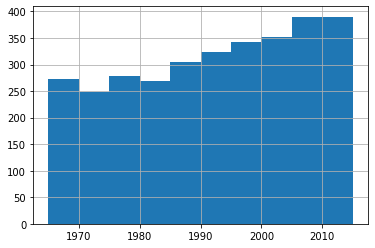

In [8]:
df[df["filteredRefs"].apply(len) == 0].Year.hist()

In [5]:
print(df_events["filteredRefs"].apply(len).max())
print(df_events["filteredRefs"].apply(len).mean())
print(df_events["Refs"].apply(len).max())
print(df_events["Refs"].apply(len).mean())

479
48.00627802690583
1557
310.247533632287


In [82]:
print(df["filteredRefs"].apply(len).max())
print(df["filteredRefs"].apply(len).mean())
print(df["Refs"].apply(len).max())
print(df["Refs"].apply(len).mean())

577
10.458577569363033
1083
67.59007424775302


In [13]:
lyrics_vectors = []
for batch_lyrics in lyrics_vectorized:
    for lyric in batch_lyrics:
        lyrics_vectors.append(lyric)
        
df["vect"] = lyrics_vectors

In [ ]:
df_events["text_vect"] = df_events.Summary.fillna(df_events.Content)
df_events["word_count"] = df_events["text_vect"].apply(lambda x : len(x.split(" ")))
df_events["text_vect"] = np.where(df_events["word_count"] > 320, df_events.Content, df_events["text_vect"])
df_events["word_count"] = df_events["text_vect"].apply(lambda x : len(x.split(" ")))

In [ ]:
events_tokenized = torch.Tensor(tokenizer.batch_encode_plus(df_events.text_vect,
                                                           pad_to_max_length=True,
                                                           padding_side = "right",
                                                           add_special_tokens=True)["input_ids"]).long()

In [ ]:
with open("events_vects.pickle", "rb") as f:
    tmp = pickle.load(f)

In [ ]:
with open("events_vects.pickle", "wb") as f:
    pickle.dump(events_vectorized, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
events_vectorized = []
for i in tqdm_notebook(df_events.text_vect):
    token_vec = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)
    events_vectorized.append(model(token_vec)[1])

In [ ]:
df[df.Artist.str.contains("dire straits")]

In [ ]:
events_vectorized = []
batch_size = 8
with torch.no_grad():
    for i in tqdm_notebook(range(0, len(df_events), batch_size)):
        batch = events_tokenized[i: min(i + batch_size, len(df_events))].to(device)
        events_vectorized.append(model(batch))
        del batch
        
events_vectorized = [x[1] for x in events_vectorized]

In [ ]:
events_vectors = []
for batch_event in events_vectorized:
    for event in batch_event:
        events_vectors.append(event.tolist())
        
df_events["vect"] = events_vectors

In [ ]:
df_events

In [ ]:
df_events.head()

In [ ]:
df_events.Refs.head(20)

In [ ]:
# df["text_vect"] = df.Summary.fillna(df_events.Content)
# df["word_count"] = df["Lyrics"].apply(lambda x : len(x.split(" ")))
# df["text_vect"] = np.where(df["word_count"] > 400, df_events.Content, df_events["text_vect"])
# df["word_count"] = df_events["text_vect"].apply(lambda x : len(x.split(" ")))

In [ ]:
tmp = [ for sent in df_events["text_vect"]]
x = torch.tensor(tmp)

## Export tsv

In [ ]:
len(model.docvecs.vectors_docs)

In [ ]:
pd.DataFrame(model.docvecs.vectors_docs).to_csv("vec.tsv", index = False, sep = "\t", header=False)

In [ ]:
df.to_csv("data.tsv", sep = "\t", index = False)